In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
_FOLDER = "../data/"
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor


import json

In [2]:
def createResponseCurve(iD,model, xValues, yValues, predicted = False):
#     fig = plt.figure(figsize=(5, 5))
    plt.scatter(xValues, yValues)
    plt.title(model + " " + iD)
    plt.xlabel("Scaled dosage")
    if(predicted):
        plt.ylabel("Predicted Normalised response")
    else:
        plt.ylabel("Normalised response")
    plt.show()


with open(_FOLDER + 'dataSplit.json') as json_file:
    trainTestSplit = json.load(json_file)

In [3]:
drugProfiles = pd.read_csv(_FOLDER+'filteredResponsesWithCCL.csv')
drugProfiles

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,HDQ-P1,1290922,344,344_1290922,20.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
1,HDQ-P1,1290922,136,136_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
2,HDQ-P1,1290922,170,170_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
3,NMC-G1,908449,170,170_908449,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
4,NMC-G1,908449,331,331_908449,10.24,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,TC-YIK,946357,1011,1011_946357,2.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5580,MKN45,925340,1149,1149_925340,5.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5581,EC-GI-10,753555,1004,1004_753555,0.10,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5582,IGROV-1,905968,1031,1031_905968,0.20,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(trainTestSplit.keys())

88

In [62]:
notIncludeColumns = ['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID','MAX_CONC']
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels

predictedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns= ['DRUG_COSMICID']+ resp_labels)

# drugId = 344
for drugId in trainTestSplit.keys():
    drugProfile = drugProfiles[drugProfiles['DRUG_ID'] == int(drugId)]
    trainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][0])]
    testData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][1])]
    testDataCosmicIds = np.array(testData['DRUGID_COSMICID'])
    notXValuesFilter = resp_labels + notIncludeColumns
    trainXValues = trainData.drop(columns = notXValuesFilter)
    trainYValues = trainData[resp_labels]

    trainX = trainXValues.reset_index(drop=True).to_numpy()
    trainY = trainYValues.reset_index(drop=True).to_numpy()

    testXValues = testData.drop(columns = notXValuesFilter)
    testYValues = testData[resp_labels]

    testX = testXValues.reset_index(drop=True).to_numpy()
    testY = testYValues.reset_index(drop=True).to_numpy()

    n_estimators = 10
    svm_bagging = MultiOutputRegressor(BaggingRegressor(base_estimator=SVR(kernel='sigmoid'), n_estimators=n_estimators))
    svm_bagging.fit(trainX, trainY)

    yTrainPredict = svm_bagging.predict(trainX)
    yTestPredict = svm_bagging.predict(testX)

    test_mse = mean_squared_error(yTrainPredict, trainY)
    trueResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    trueResult[resp_labels] = testY
    trueResults = trueResults.append(trueResult,ignore_index=True,sort=False)
    result = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    result[pred_resp_labels] = yTestPredict
    predictedResults = predictedResults.append(result,ignore_index=True,sort=False)

In [63]:
trueResults

,DRUG_COSMICID,norm_cells_0,norm_cells_1,norm_cells_2,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9
0,344_910851,1.0,0.971586,0.906044,0.954482,0.917586,0.279158,0.258352,0.233342,0.204716,0.197107
1,344_717431,1.0,1.037550,1.091360,1.143341,1.097121,0.947674,0.659068,0.011337,0.015206,0.015280
2,344_910925,1.0,1.029277,1.108623,0.851732,0.782264,0.013142,0.003812,0.004973,0.006074,0.007326
3,344_908457,1.0,1.013743,1.001765,0.947623,0.911589,0.695498,0.440803,0.173345,0.013123,0.009104
4,344_910853,1.0,0.951634,0.922052,0.687362,0.582085,0.006510,0.004951,0.006649,0.003550,0.003617
...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,1.0,0.970637,0.984342,0.953621,0.954333,0.963397,0.599178,0.515004,0.081500,0.043313
1151,330_908146,1.0,1.014952,1.022575,1.032254,0.995685,1.074410,0.453347,0.201558,0.097316,0.078932
1152,330_949088,1.0,1.004049,0.893253,0.883133,0.737194,0.656415,0.194416,0.123699,0.108118,0.094548
1153,1058_753531,1.0,1.008055,1.059813,1.063306,0.875009,0.743907,0.500262,0.303176,0.161292,0.146427


In [64]:
predictedResults

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9
0,344_910851,1.0,1.001566,0.951612,0.947223,0.892297,0.659446,0.210982,0.229521,0.045522,0.024303
1,344_717431,1.0,1.001566,0.917781,0.831532,0.641905,0.507425,0.209869,0.058504,0.045556,0.024303
2,344_910925,1.0,1.001566,0.996029,0.960842,0.853942,0.718008,0.311361,0.222797,0.045522,0.024303
3,344_908457,1.0,1.001566,0.967909,0.957042,0.998504,0.383084,0.057451,0.004209,0.045522,0.024303
4,344_910853,1.0,1.001566,0.969202,1.062763,0.930225,0.933867,0.782132,0.367947,0.045589,0.024303
...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,1.0,1.002359,0.954170,0.932655,0.862848,0.770868,0.438980,0.286561,0.140142,0.122011
1151,330_908146,1.0,1.002359,0.951854,0.896199,0.799807,0.672863,0.373937,0.254195,0.140142,0.122011
1152,330_949088,1.0,1.002359,0.944032,0.880026,0.799871,0.632535,0.340962,0.204769,0.140142,0.122011
1153,1058_753531,1.0,1.003623,0.896200,0.795391,0.650613,0.569649,0.439030,0.251115,0.128309,0.142195


In [65]:
def showTestPredResponses(drugIdCosmic):
    samplePredicted = predictedResults[predictedResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    predictedY = samplePredicted[pred_resp_labels]
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    xValues = [0, 0.111111111, 0.222222222, 0.333333333, 0.444444444, 0.555555556, 0.666666667, 0.777777778, 0.888888889, 1]
    trueY = trueY[resp_labels]
#     createResponseCurve(drugIdCosmic, 'True', xValues, trueY, predicted = False)
#     createResponseCurve(drugIdCosmic, 'Combined', xValues, combY, predicted = True)
#     createResponseCurve(drugIdCosmic, 'Ridge', xValues, ridgeY, predicted = True)
#     createResponseCurve(drugIdCosmic, 'Lasso', xValues, lassoY, predicted = True)
    plt.title(drugIdCosmic + " dosage against response")
    plt.scatter(xValues, predictedY, color='b', label='Predicted')
    plt.scatter(xValues, trueY, color='y', label='True')
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.show()

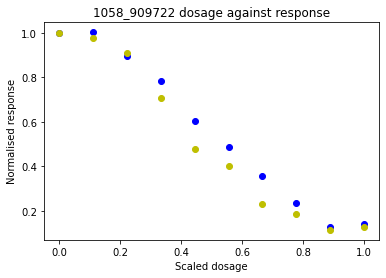

In [70]:
showTestPredResponses('1058_909722')

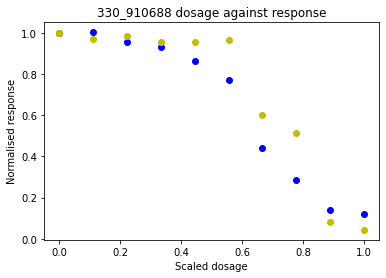

In [71]:
showTestPredResponses('330_910688')

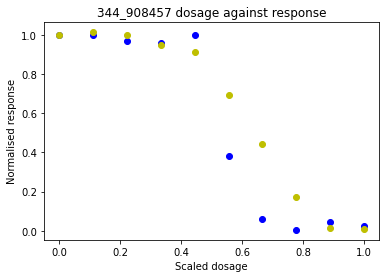

In [68]:
showTestPredResponses('344_908457')

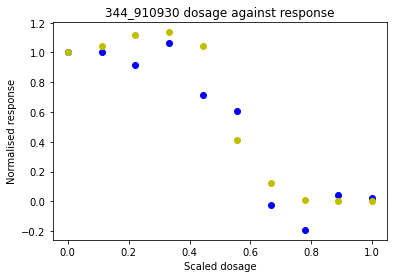

In [69]:
showTestPredResponses('344_910930')